In [4]:

import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import utils

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout, Input

tf.__version__

'2.0.0'

In [6]:
df = pd.read_csv('data/dowjone1985_2019.csv')

In [7]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1985-01-29,1277.719971,1295.489990,1266.890015,1292.619995,1292.619995,13560000
1,1985-01-30,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000
2,1985-01-31,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000
3,1985-02-01,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000
4,1985-02-04,1272.079956,1294.939941,1268.989990,1290.079956,1290.079956,11630000


In [8]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,8762.000000,8762.000000,8762.000000,8762.000000,8762.000000,8.762000e+03
mean,9741.540516,9800.407341,9680.969127,9744.180560,9744.180560,1.387696e+08
std,6379.993445,6406.101221,6351.951044,6380.505213,6380.505213,1.218227e+08
min,1243.709961,1251.209961,1235.530029,1242.050049,1242.050049,2.530000e+06
25%,3614.900086,3635.000000,3595.430053,3616.775024,3616.775024,2.666250e+07
50%,9958.229981,10031.165039,9873.945312,9958.939942,9958.939942,1.047850e+08
75%,12604.689697,12672.895020,12536.984863,12608.264893,12608.264893,2.266075e+08
max,27364.689453,27398.679688,27294.169922,27359.160156,27359.160156,2.190810e+09


In [9]:
df = df.drop('Adj Close', axis=1)

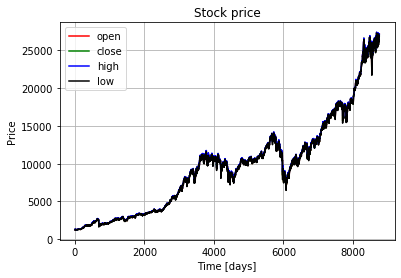

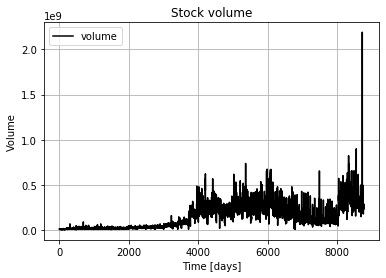

In [10]:
utils.plot_raw(df)

In [13]:
df_index = df.drop('Date', axis=1)
df_index = df_index.drop('Volume', axis=1)


cols = list(df_index.columns.values)
print('Col : ', cols)

# rearrange columns ,for training with volume
# n_cols = cols[:3] + [cols[-1]] + [cols[-2]]
# df_index = df_index[n_cols] 

# print("new Cols: ",list(df_index.columns.values))





# parameter for preprocessing #

val_set_size_percentage = 10
test_set_size_percentage = 10
seq_len = 20

#*****************************#
cols = ['Open', 'Close', 'High', 'Low']


# normalize index
df_index_norm = utils.normalize_data(df_index, cols)

# split train, val, test data

x_train, y_train, x_val, y_val, x_test, y_test = utils.load_data(df_index_norm, seq_len)

print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_val.shape = ', x_val.shape)
print('y_val.shape = ', y_val.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

Col :  ['Open', 'High', 'Low', 'Close']
x_train.shape =  (6994, 19, 4)
y_train.shape =  (6994, 4)
x_val.shape =  (874, 19, 4)
y_val.shape =  (874, 4)
x_test.shape =  (874, 19, 4)
y_test.shape =  (874, 4)


/Users/nessessence/Documents/MultimodelStockPrediction-master/utils.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data_raw = stock.as_matrix()


In [15]:
print(y_train[0]); print(x_train[0]); 

[0.00124689 0.00160513 0.00141143 0.00168701]
[[0.00130202 0.00169347 0.00120344 0.00193628]
 [0.00205429 0.002061   0.00166548 0.00175479]
 [0.00151334 0.00161354 0.0014241  0.00171229]
 [0.00127216 0.00133474 0.00131396 0.00136577]
 [0.0010861  0.00167244 0.00128403 0.00183902]
 [0.00192757 0.00190917 0.00165281 0.00165332]
 [0.00157651 0.00165561 0.00151734 0.00147566]
 [0.00158072 0.00175275 0.00169925 0.00183902]
 [0.0017752  0.00175696 0.00175872 0.00183481]
 [0.00169519 0.00155006 0.00127136 0.00130221]
 [0.00105241 0.00122077 0.00118233 0.00132327]
 [0.00130623 0.00204418 0.00149586 0.00213921]
 [0.0022235  0.00215394 0.00184776 0.00175479]
 [0.00174151 0.0017233  0.00151734 0.00153041]
 [0.00138203 0.00138522 0.00145787 0.00147566]
 [0.00139505 0.0015795  0.00141987 0.00157291]
 [0.00140347 0.0013726  0.0014241  0.00141631]
 [0.00131044 0.00135157 0.0013224  0.00129378]
 [0.00100609 0.00122077 0.00108908 0.00135735]]


In [16]:
df_index.head(20)

,Open,High,Low,Close
0,0.001302,0.001693,0.001203,0.001936
1,0.002054,0.002061,0.001665,0.001755
2,0.001513,0.001614,0.001424,0.001712
3,0.001272,0.001335,0.001314,0.001366
4,0.001086,0.001672,0.001284,0.001839
5,0.001928,0.001909,0.001653,0.001653
6,0.001577,0.001656,0.001517,0.001476
7,0.001581,0.001753,0.001699,0.001839
8,0.001775,0.001757,0.001759,0.001835
9,0.001695,0.001550,0.001271,0.001302


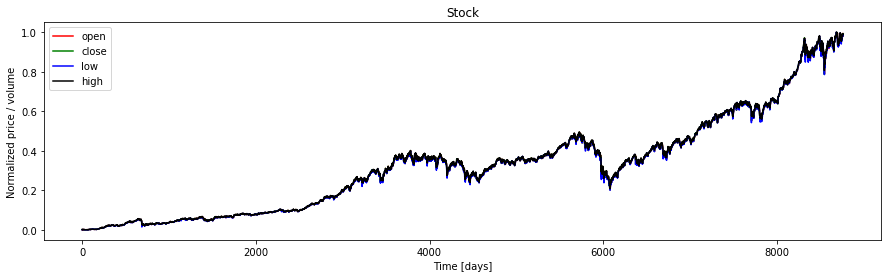

In [14]:
plt.figure(figsize=(15, 4))
plt.plot(df_index_norm['Open'], color='red', label='open')
plt.plot(df_index_norm['Close'], color='green', label='close')
plt.plot(df_index_norm['Low'], color='blue', label='low')
plt.plot(df_index_norm['High'], color='black', label='high')
plt.title('Stock')
plt.xlabel('Time [days]')
plt.ylabel('Normalized price / volume')
plt.legend(loc='best')
plt.show()

In [15]:
from tensorflow.keras import backend as K
K.clear_session()

In [22]:
from tensorflow.keras.layers import Bidirectional,TimeDistributed,BatchNormalization,Flatten
n_steps = seq_len - 1

def get_bi_gru():
    
    input1 = Input(shape=(19,4,))
    x = Bidirectional(LSTM(200,activation='relu', return_sequences=True))(input1)
    x = TimeDistributed(BatchNormalization())(x)
    x = LSTM(200,activation='relu')(x)
    #x = Dense(200,activation='relu')(x)
    x = (BatchNormalization())(x)
    out = Dense(4,activation='linear')(x)

    
    
    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(0.005),
                loss='mse',
                metrics=['mse'])   
    
    return model

In [23]:
model = get_bi_gru()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 19, 4)]           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 19, 400)           328000    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 19, 400)           1600      
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               480800    
_________________________________________________________________
batch_normalization_3 (Batch (None, 200)               800       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 804       
Total params: 812,004
Trainable params: 810,804
Non-trainable params: 1,200
_________________________________________________

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
print('start training ')


weight_path_model = "saved_model/baseline.h5"
callbacks_list_model = [
    ModelCheckpoint(
             weight_path_model,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=2
        ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, min_lr=0.0001)
]

#################
batch_size = 256
epochs = 100
#################

history = model.fit(x_train, y_train, epochs=epochs, verbose=2, callbacks=callbacks_list_model,
          validation_data=(x_val, y_val),batch_size=batch_size) #batch_size=batch_size




start training 
Train on 6994 samples, validate on 874 samples
Epoch 1/100

Epoch 00001: val_loss improved from inf to 10.92374, saving model to saved_model/baseline.h5
6994/6994 - 12s - loss: 0.4851 - mse: 0.4851 - val_loss: 10.9237 - val_mse: 10.9237
Epoch 2/100

Epoch 00002: val_loss improved from 10.92374 to 1.83603, saving model to saved_model/baseline.h5
6994/6994 - 9s - loss: 0.0123 - mse: 0.0123 - val_loss: 1.8360 - val_mse: 1.8360
Epoch 3/100

Epoch 00003: val_loss did not improve from 1.83603
6994/6994 - 9s - loss: 0.0035 - mse: 0.0035 - val_loss: 8.4069 - val_mse: 8.4069
Epoch 4/100

Epoch 00004: val_loss improved from 1.83603 to 0.52857, saving model to saved_model/baseline.h5
6994/6994 - 9s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.5286 - val_mse: 0.5286
Epoch 5/100

Epoch 00005: val_loss improved from 0.52857 to 0.11781, saving model to saved_model/baseline.h5
6994/6994 - 10s - loss: 7.6868e-04 - mse: 7.6868e-04 - val_loss: 0.1178 - val_mse: 0.1178
Epoch 6/100

Epoch 000

Epoch 50/100

Epoch 00050: val_loss improved from 0.02688 to 0.01818, saving model to saved_model/baseline.h5
6994/6994 - 9s - loss: 1.8969e-04 - mse: 1.8969e-04 - val_loss: 0.0182 - val_mse: 0.0182
Epoch 51/100

Epoch 00051: val_loss improved from 0.01818 to 0.01610, saving model to saved_model/baseline.h5
6994/6994 - 11s - loss: 2.5263e-04 - mse: 2.5263e-04 - val_loss: 0.0161 - val_mse: 0.0161
Epoch 52/100

Epoch 00052: val_loss improved from 0.01610 to 0.00931, saving model to saved_model/baseline.h5
6994/6994 - 11s - loss: 2.5370e-04 - mse: 2.5370e-04 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 53/100

Epoch 00053: val_loss improved from 0.00931 to 0.00549, saving model to saved_model/baseline.h5
6994/6994 - 10s - loss: 1.5224e-04 - mse: 1.5224e-04 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 54/100

Epoch 00054: val_loss did not improve from 0.00549
6994/6994 - 9s - loss: 1.5599e-04 - mse: 1.5599e-04 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 55/100

Epoch 00055: val_loss improved fr

Epoch 98/100

Epoch 00098: val_loss did not improve from 0.00019
6994/6994 - 9s - loss: 1.5237e-04 - mse: 1.5237e-04 - val_loss: 5.6803e-04 - val_mse: 5.6803e-04
Epoch 99/100

Epoch 00099: val_loss did not improve from 0.00019
6994/6994 - 10s - loss: 1.6457e-04 - mse: 1.6457e-04 - val_loss: 8.5219e-04 - val_mse: 8.5219e-04
Epoch 100/100

Epoch 00100: val_loss did not improve from 0.00019
6994/6994 - 10s - loss: 1.7375e-04 - mse: 1.7375e-04 - val_loss: 7.4245e-04 - val_mse: 7.4245e-04


In [19]:
#model.save("saved_model/model00epVolume.h5")

In [20]:
#from tensorflow.keras.models import load_model
#model = load_model("saved_model/model500ep_novolume.h5")


In [25]:
x_train.shape
y_train.shape

(6994, 4)

In [26]:
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)
y_test_pred = model.predict(x_test)

In [27]:
print(y_test_pred[0])

[0.62794006 0.6808709  0.61270237 0.66844046]


In [30]:
def plot_compare(x):
    Col = {'Open':0, 'High':1, 'Low':2, 'Close':3, 'sma5':4, 'sma10':5, 'sma25':6, 'sma75':7, 'sma125':8, 'sma200':9}
    ft = Col[x]
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)

    plt.plot(np.arange(y_train.shape[0]), y_train[:, ft], color='blue', label='train target')

    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_val.shape[0]), y_val[:, ft], 
             color='gray', label='val target')
    plt.plot(np.arange(y_train.shape[0] + y_val.shape[0], y_train.shape[0] + y_val.shape[0] + y_test.shape[0]),
            y_test[:, ft], color='black', label='test target')
    plt.plot(np.arange(y_train_pred.shape[0]), y_train_pred[:, ft],
            color='red', label='train prediction') 
    plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0] + y_val_pred.shape[0]),
            y_val_pred[:, ft], color='orange', label='val prediction')
    plt.plot(np.arange(y_train_pred.shape[0] + y_val_pred.shape[0],
            y_train_pred.shape[0] + y_val_pred.shape[0] + y_test_pred.shape[0]),
            y_test_pred[:, ft], color ='green', label='test prediction')
    plt.title('past and future stock price')
    plt.xlabel('Time [Days]')
    plt.ylabel('Normalized price')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_test.shape[0]),
            y_test[:, ft], color='black', label='test target')
    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_test_pred.shape[0]),
            y_test_pred[:, ft], color='green', label='test prediction')
    plt.title('future stock prices '+x)
    plt.xlabel('Time [Days]')
    plt.ylabel('Normalized price')
    plt.legend(loc='best')


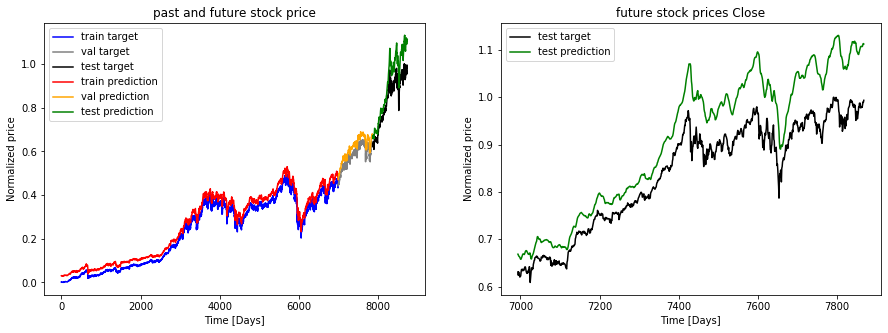

In [31]:
plot_compare('Close')

In [33]:
model.evaluate(x_test,y_test)

874/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.24793749586071656, 0.24793749]